# 准备

## 环境

In [1]:
%matplotlib inline
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as stm
from statsmodels.regression.rolling import RollingOLS
plt.style.use('seaborn-dark')
plt.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体,用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题
plt.rcParams['figure.figsize']=(20, 10)

## 常量

In [2]:
YTD=250#trading days in one year
RFR=4e-2#risk free rate
WINDOW=30# move window

# A股数据

1. 股票因子数据
2. 行业指数价格
3. 行业指数信息
4. 市场组合指数（沪深300指数）
5. 股票价格
6. 股票行业归属
7. 沪深300成分股权重表

## 加载数据

In [3]:
h5 = pd.HDFStore('data/data.h5', mode='r')  
h5.keys()

['/fac',
 '/ind_close',
 '/ind_info',
 '/inx_close',
 '/obj_close',
 '/obj_cls',
 '/obj_weight']

## 股票因子数据

In [4]:
h5['fac'].head()

,avg_turn_20,avg_turn_240,avg_turn_60,beta_csi300_60_0,close_0,date,fs_common_equity_0,fs_net_cash_flow_ttm_0,fs_net_profit_yoy_0,fs_non_current_liabilities_0,...,fs_total_liability_0,instrument,market_cap_0,market_cap_float_0,pb_lf_0,pe_ttm_0,return_60,swing_volatility_60_0,volatility_60_0,west_eps_ftm_0
0,0.361890,0.364016,0.241283,0.798543,32.895355,2019-03-04,3.696409e+10,-2.738063e+09,8.335700,2.171018e+10,...,9.037635e+10,600297.SHA,4.116363e+10,4.079482e+10,1.119917,9.966406,1.183529,0.017560,0.022313,0.5308
1,1.166124,0.571547,0.827291,0.753365,294.284088,2019-03-04,3.234399e+10,2.099414e+09,4.464700,1.699484e+10,...,5.457291e+10,600089.SHA,2.956744e+10,2.956593e+10,1.014530,12.976037,1.162044,0.009117,0.015089,0.6978
2,5.080401,3.110909,3.564228,1.324330,54.565777,2019-03-04,8.044239e+09,-1.128414e+08,74.143097,1.218728e+09,...,1.136024e+10,603799.SHA,3.196187e+10,3.158182e+10,3.973262,11.796223,1.158496,0.023050,0.030983,2.8106
3,1.151961,0.963841,0.791393,0.503264,67.877487,2019-03-04,7.306716e+09,6.637488e+08,11.567500,3.088342e+07,...,1.013928e+09,000408.SZA,2.384560e+10,5.341728e+09,3.263519,18.449429,1.050967,0.010574,0.015331,0.7142
4,3.082663,1.035434,2.424723,0.713421,109.131134,2019-03-04,2.432507e+10,5.131218e+09,-92.448303,3.669428e+10,...,7.914598e+10,600157.SHA,2.671546e+10,2.671546e+10,1.098269,120.433922,1.221591,0.034369,0.050207,0.0691


## 行业指数价格

In [5]:
h5['ind_close'].head()

,instrument,date,s_dq_close
0,801880.SI,2019-01-02,3364.27
1,801740.SI,2019-01-02,894.03
2,801210.SI,2019-01-02,4735.80
3,801200.SI,2019-01-02,2964.57
4,801750.SI,2019-01-02,3150.27


## 行业指数信息

In [6]:
h5['ind_info']

,industriesalias,industriesname,memo
356,801080.SI,电子,270000
968,801770.SI,通信,730000
1067,801040.SI,钢铁,230000
1084,801180.SI,房地产,430000
1661,801890.SI,机械设备,640000
2164,801720.SI,建筑装饰,620000
2833,801110.SI,家用电器,330000
3360,801780.SI,银行,480000
4289,801010.SI,农林牧渔,110000
4573,801200.SI,商业贸易,450000


## 市场组合指数（沪深300指数）

In [7]:
h5['inx_close'].head()

,instrument,date,s_dq_close
0,000300.SHA,2019-01-02,2969.5353
1,000300.SHA,2019-01-03,2964.8421
2,000300.SHA,2019-01-04,3035.8741
3,000300.SHA,2019-01-07,3054.3030
4,000300.SHA,2019-01-08,3047.7035


## 股票价格

In [8]:
h5['obj_close'].head()

,instrument,date,s_dq_adjclose
0,600518.SHA,2019-01-02,372.15
1,600549.SHA,2019-01-02,153.67
2,600570.SHA,2019-01-02,724.17
3,600023.SHA,2019-01-02,7.23
4,000786.SZA,2019-01-02,142.95


## 股票行业归属

In [9]:
h5['obj_cls'].head()

,date,instrument,industry_sw_level1
0,2019-03-04,600415.SHA,450000
1,2019-03-04,600299.SHA,220000
2,2019-03-04,600309.SHA,220000
3,2019-03-04,600660.SHA,280000
4,2019-03-04,600177.SHA,430000


## 沪深300成分股权重表

In [10]:
h5['obj_weight'].head()

,date,instrument,weight
401,2019-01-02,002241.SZA,0.001426
402,2019-01-02,002230.SZA,0.003842
403,2019-01-02,002179.SZA,0.001418
404,2019-01-02,002153.SZA,0.000884
405,2019-01-02,002146.SZA,0.001472


# 回归分析和资产定价的函数

步骤：
1. 时序回归>因子暴漏值
2. 截面回归>因子收益值
3. 近期因子（动量法则）>因子预期值
4. 因子收益+因子预期值>资产预期收益率

In [11]:
# 总体方差为零情况（分母为零的处理）
def ols_r2_tss_0(a):
    a[abs(a)==np.inf]=np.nan
    return a
# 总体回归R2
ols_tot_r2=lambda y,x:(stm.OLS(
    endog=y,exog=x,missing='drop')
                       .fit().rsquared)
# 滚动回归R2
ols_sam_r2=lambda y,x:ols_r2_tss_0(stm.regression.rolling.RollingOLS(
    endog=y,exog=x,missing='drop',window=WINDOW)
                       .fit().rsquared).mean(axis=0)
# 总体回归系数
ols_tot_p=lambda y,x:(stm.OLS(
    endog=y,exog=x,missing='drop')
                      .fit().params)
# 滚动回归系数
ols_sam_p=lambda y,x:(stm.regression.rolling.RollingOLS(
    endog=y,exog=x,missing='drop',window=WINDOW)
                      .fit().params.mean(axis=0))
# 内联合并因变量和自变量,获得收益数据和因子个数
def f_dm(y,*x):
    d=pd.concat(objs=(y,*x),axis=1,join='inner')
    return d,len(x)
# ols
def f_ols(d,m,ols):
    return (d.iloc[:,:-m].apply(func=ols,args=(d.iloc[:,-m:],),axis=0,raw=False,))
# 时序回归R2
def f_t_r2(y,*x,ols):
    return f_ols(*f_dm(y,*x),ols=ols).mean(axis=0)
# 经典截面回归（均值>回归）
def f_c_rg(y,*x,ols):
    d,m=f_dm(y,*x)
    f=f_ols(d,m,ols=ols).T
    d=pd.concat(objs=(d.iloc[:,:-m].mean(axis=0),f),axis=1,join='inner')
    return stm.OLS(endog=d.iloc[:,0],exog=d.iloc[:,1:],missing='drop').fit()
# FM 界面回归（回归>均值）
def f_c_fm(y,*x,ols):
    d,m=f_dm(y,*x)
    f=f_ols(d,m,ols=ols).T  
    # 单期截面回归求因子溢价
    def _f(y,x):
        a=ols_tot_p(y,x)
        b=y-(x*a).sum(axis=1)
        return pd.concat(objs=(a,b),axis=0)
    y=d.iloc[:,:-m].apply(func=_f,args=(f,),axis=1,raw=False)
    a=y.iloc[:,:m].mean(axis=0)
    r=d.iloc[:,:-m].mean(axis=0)
    p=(f*a).sum(axis=1)
    return a,1-((r-p)**2).mean(axis=0)/r.var(ddof=0)
# 时序回归计算因子值
def f_t_f(y,*x,ols):
    d,m=f_dm(y,*x)
    d=d.iloc[-WINDOW:,:]
    return f_ols(d,m,ols=ols).T      

#  Beta

## MKT
市场因子（market factor）

In [12]:
fac_mkt=np.log(h5['inx_close'].iloc[:,1:].set_index(['date',])).diff().iloc[:,0]-RFR/YTD
fac_mkt.name='mkt'

## 行业指数$\beta$

### 总体法

行业指数的收益率序列

In [13]:
ind_ret=h5['ind_close'].set_index('date').groupby('instrument').apply(lambda i:np.log(i).diff().iloc[1:,:])
ind_ret=ind_ret.unstack(0)
ind_ret.columns=ind_ret.columns.droplevel(0)

In [14]:
ind_ret.isna().sum().sum()

0

In [15]:
ind_ret.head()

instrument,801010.SI,801020.SI,801030.SI,801040.SI,801050.SI,801080.SI,801110.SI,801120.SI,801130.SI,801140.SI,...,801720.SI,801730.SI,801740.SI,801750.SI,801760.SI,801770.SI,801780.SI,801790.SI,801880.SI,801890.SI
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.001376,0.000031,-0.009764,0.004839,0.010878,-0.018785,-0.005360,-0.019283,-0.008358,-0.008521,...,-0.001549,-0.001338,0.031717,-0.005181,-0.005659,-0.023717,0.008808,0.015021,-0.009563,-0.002140
2019-01-04,0.022919,0.019222,0.019993,0.016694,0.023939,0.020810,0.021326,0.018145,0.018216,0.020109,...,0.022616,0.030395,0.023771,0.038957,0.029046,0.018404,0.020393,0.042590,0.015538,0.024149
2019-01-07,0.023130,0.014805,0.014974,0.013634,0.018326,0.028248,0.004181,0.008772,0.013107,0.013747,...,0.012573,0.032052,0.042510,0.027252,0.016918,0.031417,-0.002179,-0.003469,0.014377,0.023132
2019-01-08,-0.007305,0.000606,0.000957,-0.002930,-0.013494,0.004085,0.001549,-0.003738,0.002463,-0.001010,...,0.000078,-0.000880,-0.018743,-0.005174,0.000602,-0.005516,-0.004347,-0.003220,-0.001600,0.001473
2019-01-09,-0.000361,0.001533,0.008862,0.007602,0.000267,0.007476,0.038257,0.015079,0.005175,0.006200,...,-0.001771,0.002945,-0.010679,-0.000390,0.002250,0.005068,0.008510,0.009539,0.017082,-0.001849


市场组合的收益率序列

In [16]:
inx_ret=np.log(h5['inx_close'].set_index('date').s_dq_close).diff().iloc[1:]

In [17]:
ind_ret.isna().sum().sum()

0

In [18]:
inx_ret.head()

date
2019-01-03   -0.001582
2019-01-04    0.023676
2019-01-07    0.006052
2019-01-08   -0.002163
2019-01-09    0.010046
Name: s_dq_close, dtype: float64

检查行数是否一致

In [19]:
ind_ret.shape,inx_ret.shape

((289, 28), (289,))

合并行业和市场的收益率序列

In [20]:
x=ind_ret.merge(right=inx_ret,left_index=True,right_index=True,how='outer')

计算各资产与市场组合的协方差

$\beta=\frac{cov(s,m)}{\sigma_m^2}=\frac{\rho\sigma_s}{\sigma_m}=一元线性回归系数$

In [21]:
b,m=x.corrwith(x.iloc[:,-1])*x.std()/x.iloc[:,-1].std(),x.mean()*YTD

In [22]:
b.index

Index(['801010.SI', '801020.SI', '801030.SI', '801040.SI', '801050.SI',
       '801080.SI', '801110.SI', '801120.SI', '801130.SI', '801140.SI',
       '801150.SI', '801160.SI', '801170.SI', '801180.SI', '801200.SI',
       '801210.SI', '801230.SI', '801710.SI', '801720.SI', '801730.SI',
       '801740.SI', '801750.SI', '801760.SI', '801770.SI', '801780.SI',
       '801790.SI', '801880.SI', '801890.SI', 's_dq_close'],
      dtype='object')

In [23]:
_kv={i[0]:i[1] for i in h5['ind_info'].values}
_kv['s_dq_close']='市场组合'

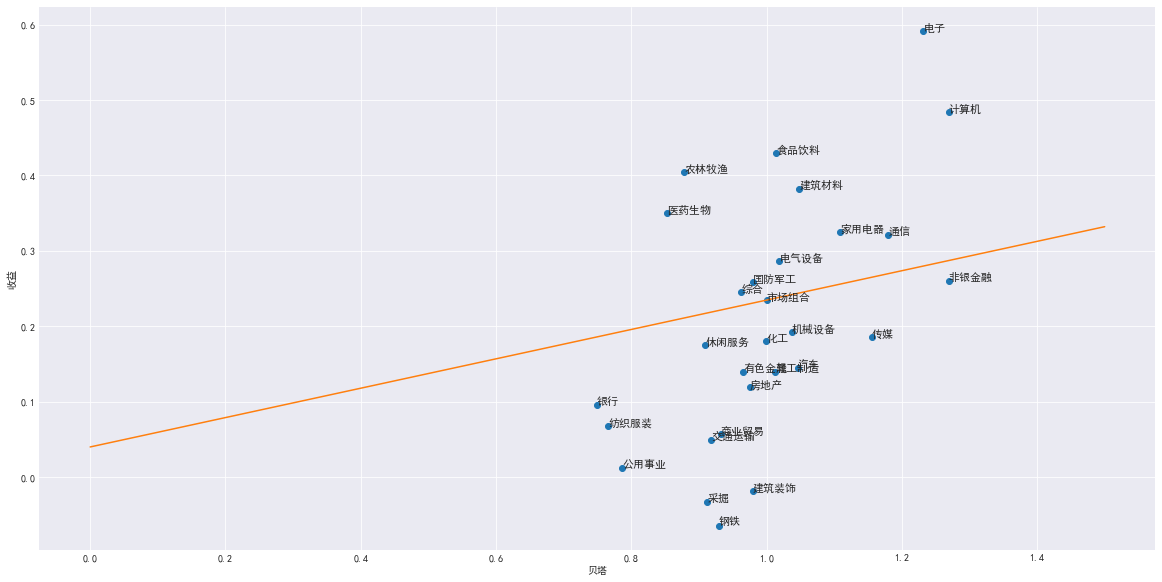

In [24]:
plt.grid(True)
plt.xlabel('贝塔')
plt.ylabel('收益')
plt.plot(b,m,'o')
_=list(map(lambda x:plt.text(*x,fontsize=11),zip(b,m,[_kv[i] for i in b.index])))
plt.plot(*np.array([[i,i*(x.iloc[:,-1].mean()*YTD-RFR)+RFR] for i in np.linspace(0,1.5,3)]).T)

***因子模型术语***：
1. 因子组合收益：因子组合的收益,例如：市场组合（沪深300）收益率；
2. 因子载荷（暴漏）：因子值，例如：$\beta$系统性风险系数；
3. 因子溢价（收益）：因子值截面回归的系数；

In [25]:
x.columns

Index(['801010.SI', '801020.SI', '801030.SI', '801040.SI', '801050.SI',
       '801080.SI', '801110.SI', '801120.SI', '801130.SI', '801140.SI',
       '801150.SI', '801160.SI', '801170.SI', '801180.SI', '801200.SI',
       '801210.SI', '801230.SI', '801710.SI', '801720.SI', '801730.SI',
       '801740.SI', '801750.SI', '801760.SI', '801770.SI', '801780.SI',
       '801790.SI', '801880.SI', '801890.SI', 's_dq_close'],
      dtype='object')

In [26]:
# 市场因子解释性：单个资产时间序列回归的检验
stm.OLS(endog=x.loc[:,'s_dq_close'],exog=stm.add_constant(x.iloc[:,-1]-RFR/YTD)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             s_dq_close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.075e+34
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        16:02:13   Log-Likelihood:                 11334.
No. Observations:                 289   AIC:                        -2.266e+04
Df Residuals:                     287   BIC:                        -2.266e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   1.33e-19    1.2e+15      0.000       0.000       0.000
s_dq_close     1.0000   9.65e-18   1.04e+17      0.000       1.000       1.000
==============================================================================
Omnibus:                       62.902   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              450.830
Skew:                          -0.640   Prob(JB):                     1.27e-98
Kurtosis:                       8.983   Cond. No.                         72.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
stm.OLS(endog=x.loc[:,'801230.SI'],exog=stm.add_constant(x.iloc[:,-1]-RFR/YTD)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              801230.SI   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     476.5
Date:                Tue, 05 May 2020   Prob (F-statistic):           6.23e-63
Time:                        16:02:13   Log-Likelihood:                 912.63
No. Observations:                 289   AIC:                            -1821.
Df Residuals:                     287   BIC:                            -1814.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.381      0.703      -0.001       0.001
s_dq_close     0.9625      0.044     21.830      0.000       0.876       1.049
==============================================================================
Omnibus:                       14.685   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.092
Skew:                          -0.094   Prob(JB):                     1.45e-08
Kurtosis:                       4.721   Cond. No.                         72.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# 总体均值的界面回归检验
stm.OLS(endog=x.iloc[:,:-1].mean(),exog=stm.add_constant(b.iloc[:-1])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     12.50
Date:                Tue, 05 May 2020   Prob (F-statistic):            0.00155
Time:                        16:02:13   Log-Likelihood:                 171.51
No. Observations:                  28   AIC:                            -339.0
Df Residuals:                      26   BIC:                            -336.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -2.436      0.022      -0.003      -0.000
0              0.0027      0.001      3.536      0.002       0.001       0.004
==============================================================================
Omnibus:                        1.016   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.602   Jarque-Bera (JB):                1.008
Skew:                           0.378   Prob(JB):                        0.604
Kurtosis:                       2.460   Cond. No.                         14.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
print(f_t_r2(ind_ret,fac_mkt,ols=ols_tot_r2))
f_c_rg(ind_ret,fac_mkt,ols=ols_tot_p).summary()

0.6664409467216359


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.689
Model:                            OLS   Adj. R-squared (uncentered):              0.677
Method:                 Least Squares   F-statistic:                              59.74
Date:                Tue, 05 May 2020   Prob (F-statistic):                    2.60e-08
Time:                        16:02:13   Log-Likelihood:                          168.73
No. Observations:                  28   AIC:                                     -335.5
Df Residuals:                      27   BIC:                                     -334.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt            0.0009      0.000      7.729      0.000       0.001       0.001
==============================================================================
Omnibus:                        0.901   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                0.916
Skew:                           0.357   Prob(JB):                        0.633
Kurtosis:                       2.474   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 样本法
通过时间窗口滚动计算$\beta$系数样本，然后求期望

In [30]:
_w=WINDOW
x=ind_ret.merge(right=inx_ret,left_index=True,right_index=True,how='inner')
a=(
    x.rolling(window=_w).corr(x.iloc[:,-1])*
    x.rolling(window=_w).std()/
    np.repeat(np.reshape(x.iloc[:,-1].rolling(window=_w).std().values,(-1,1)),x.shape[1],axis=1)
)
a.columns=[_kv[i] for i in a.columns]

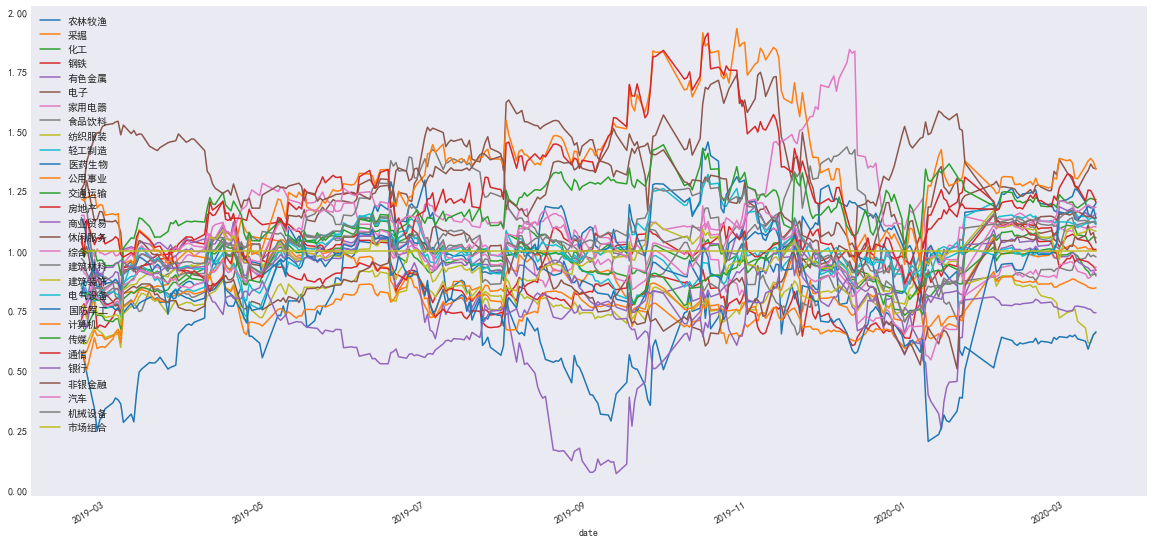

In [31]:
a.plot()

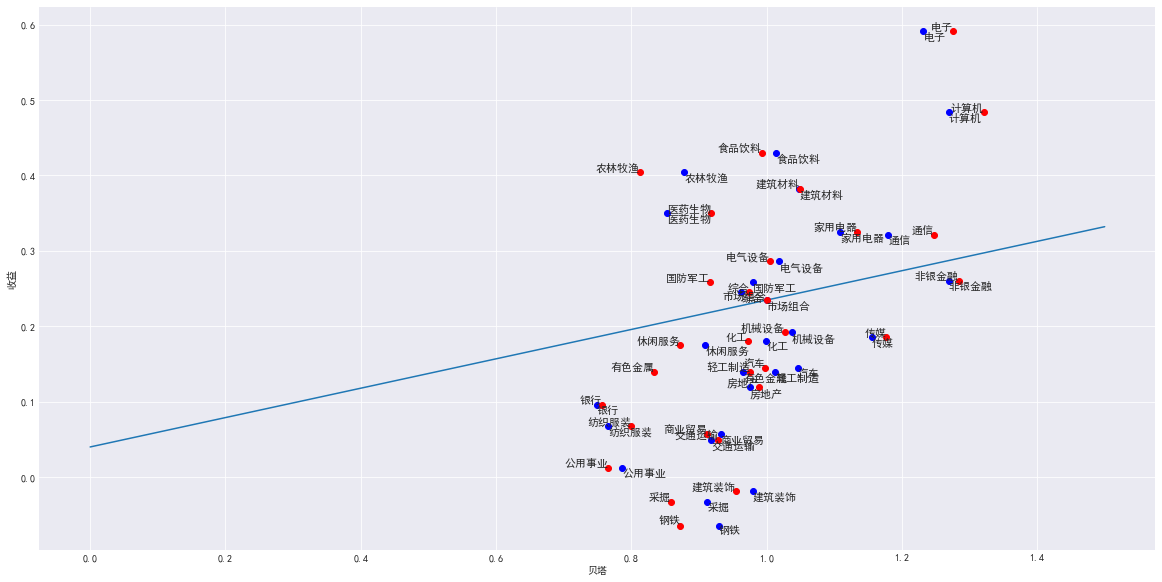

In [32]:
plt.grid(True)
plt.xlabel('贝塔')
plt.ylabel('收益')
plt.plot(b,m,'bo')
_=list(map(lambda x:plt.text(*x,fontsize=11,horizontalalignment='left',verticalalignment='top'),zip(b,m,[_kv[i] for i in b.index])))
plt.plot(*np.array([[i,i*(x.iloc[:,-1].mean()*YTD-RFR)+RFR] for i in np.linspace(0,1.5,3)]).T)

_=list(map(lambda x:plt.text(*x,fontsize=11,horizontalalignment='right',verticalalignment='bottom'),zip(a.mean(axis=0),m,a.columns)))
plt.plot(a.mean(axis=0),m,'ro')

1. 总体法和样本法区别不大；
2. 总体法向内集中，样本法向外发散；

In [33]:
# 总体均值的界面回归检验
stm.OLS(endog=x.iloc[:,:-1].mean().values,exog=stm.add_constant(a.mean().iloc[:-1].values)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     15.47
Date:                Tue, 05 May 2020   Prob (F-statistic):           0.000556
Time:                        16:02:15   Log-Likelihood:                 172.55
No. Observations:                  28   AIC:                            -341.1
Df Residuals:                      26   BIC:                            -338.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -2.608      0.015      -0.003      -0.000
x1             0.0025      0.001      3.934      0.001       0.001       0.004
==============================================================================
Omnibus:                        1.517   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.279
Skew:                           0.497   Prob(JB):                        0.528
Kurtosis:                       2.674   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 个股$\beta$

### 总体法

In [34]:
obj_ret=h5['obj_close'].set_index('date').groupby('instrument').apply(lambda i:np.log(i).diff().iloc[1:,:])
obj_ret=obj_ret.unstack(0)
obj_ret.columns=obj_ret.columns.droplevel(0)

In [35]:
x=obj_ret.isna().sum()
x[x>1]

instrument
002945.SZA     11
002958.SZA     54
600928.SHA     37
600968.SHA    115
600989.SHA     87
601236.SHA    122
601298.SHA     13
601698.SHA    117
dtype: int64

In [36]:
obj_ret.head()

instrument,000001.SZA,000002.SZA,000063.SZA,000069.SZA,000100.SZA,000157.SZA,000166.SZA,000333.SZA,000338.SZA,000402.SZA,...,603259.SHA,603260.SHA,603288.SHA,603501.SHA,603799.SHA,603833.SHA,603858.SHA,603899.SHA,603986.SHA,603993.SHA
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.009743,0.007087,-0.040680,0.001684,0.007895,0.014292,0.022512,-0.006638,-0.009285,-0.017517,...,-0.004458,-0.024710,-0.035348,-0.018426,0.002405,-0.018641,-0.004917,-0.001486,-0.010094,0.008210
2019-01-04,0.049411,0.035104,0.022115,0.024755,0.015605,0.011338,0.067851,0.021568,0.015894,0.037799,...,0.013453,0.022405,0.007376,0.029729,0.027951,0.023120,0.024912,-0.017171,0.025484,0.023435
2019-01-07,-0.001026,0.004802,0.041835,0.009758,0.034246,0.013933,-0.009646,0.000000,0.006566,0.028972,...,-0.005249,0.011473,0.013188,0.044304,0.011150,0.040659,0.009009,0.003525,0.035130,0.015848
2019-01-08,-0.008255,-0.001997,-0.006029,-0.011358,0.066329,0.005503,0.004835,-0.003511,0.000000,0.002969,...,-0.009322,-0.006409,-0.015204,-0.022406,-0.014191,-0.010599,-0.003088,-0.023052,-0.027435,-0.010273
2019-01-09,0.028575,0.013114,0.001018,0.019411,-0.007026,0.002781,0.000000,0.056442,0.012936,0.023698,...,0.008491,0.005267,0.035468,0.002995,-0.027314,0.030144,-0.001407,0.021375,0.014928,0.002380


In [37]:
[i.shape for i in  (obj_ret,inx_ret)]

[(289, 335), (289,)]

In [38]:
x=obj_ret.merge(right=inx_ret,left_index=True,right_index=True,how='outer')

In [39]:
[i.shape for i in  (obj_ret,inx_ret,x)]

[(289, 335), (289,), (289, 336)]

In [40]:
b,m=x.corrwith(x.iloc[:,-1])*x.std()/x.iloc[:,-1].std(),x.mean()*YTD

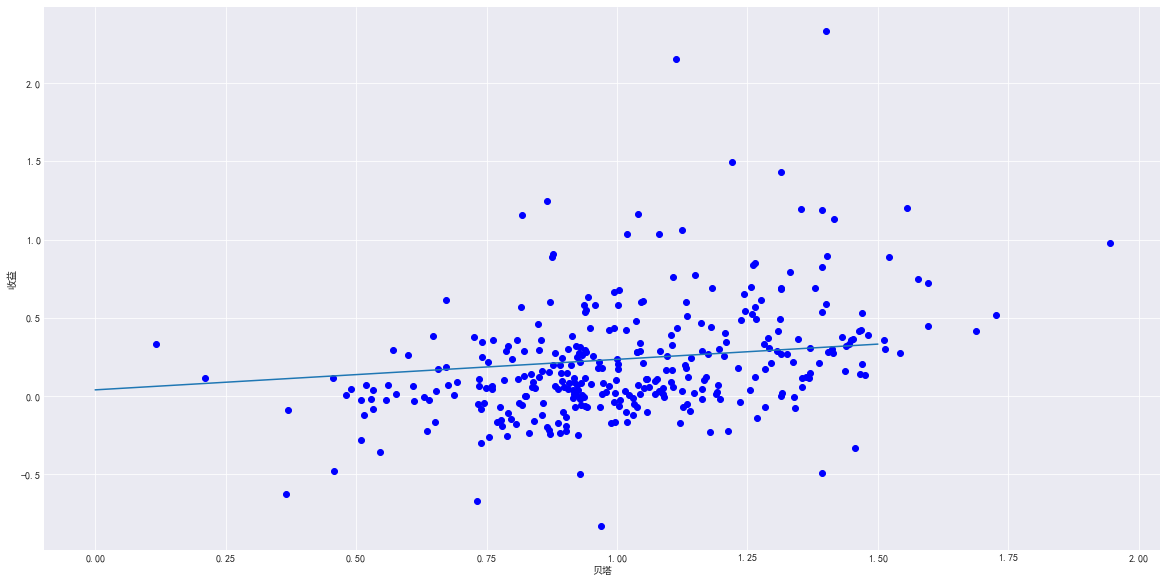

In [41]:
plt.grid(True)
plt.xlabel('贝塔')
plt.ylabel('收益')
plt.plot(b,m,'bo')
plt.plot(*np.array([[i,i*(x.iloc[:,-1].mean()*YTD-RFR)+RFR] for i in np.linspace(0,1.5,3)]).T)

In [42]:
# 总体均值的界面回归检验
stm.OLS(endog=x.iloc[:,:-1].mean(),exog=stm.add_constant(b.iloc[:-1])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     60.29
Date:                Tue, 05 May 2020   Prob (F-statistic):           1.02e-13
Time:                        16:02:17   Log-Likelihood:                 1733.2
No. Observations:                 335   AIC:                            -3462.
Df Residuals:                     333   BIC:                            -3455.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.000     -4.538      0.000      -0.002      -0.001
0              0.0021      0.000      7.765      0.000       0.002       0.003
==============================================================================
Omnibus:                      127.554   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              611.590
Skew:                           1.546   Prob(JB):                    1.57e-133
Kurtosis:                       8.853   Cond. No.                         7.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
x=obj_ret,fac_mkt
print(f_t_r2(*x,ols=ols_tot_r2))
f_c_rg(*x,ols=ols_tot_p).summary()

0.39118733624722146


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.334
Model:                            OLS   Adj. R-squared (uncentered):              0.332
Method:                 Least Squares   F-statistic:                              167.8
Date:                Tue, 05 May 2020   Prob (F-statistic):                    2.22e-31
Time:                        16:02:18   Log-Likelihood:                          1724.9
No. Observations:                 335   AIC:                                     -3448.
Df Residuals:                     334   BIC:                                     -3444.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt            0.0009   7.25e-05     12.955      0.000       0.001       0.001
==============================================================================
Omnibus:                      130.733   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              618.788
Skew:                           1.596   Prob(JB):                    4.28e-135
Kurtosis:                       8.843   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. 市场因子对于资产价格的解释性并不是很好；

### 样本法

In [44]:
_w=WINDOW
x=obj_ret.merge(right=inx_ret,left_index=True,right_index=True,how='outer')
a=(
    x.rolling(window=_w).corr(x.iloc[:,-1])*
    x.rolling(window=_w).std()/
    np.repeat(np.reshape(x.iloc[:,-1].rolling(window=_w).std().values,(-1,1)),x.shape[1],axis=1)
)

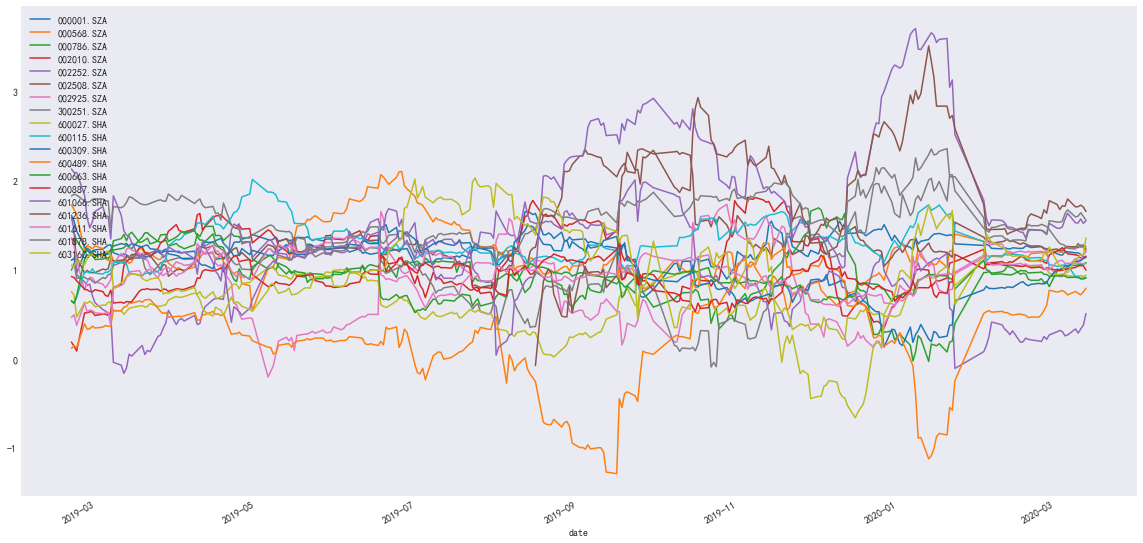

In [45]:
a.iloc[:,::18].plot()

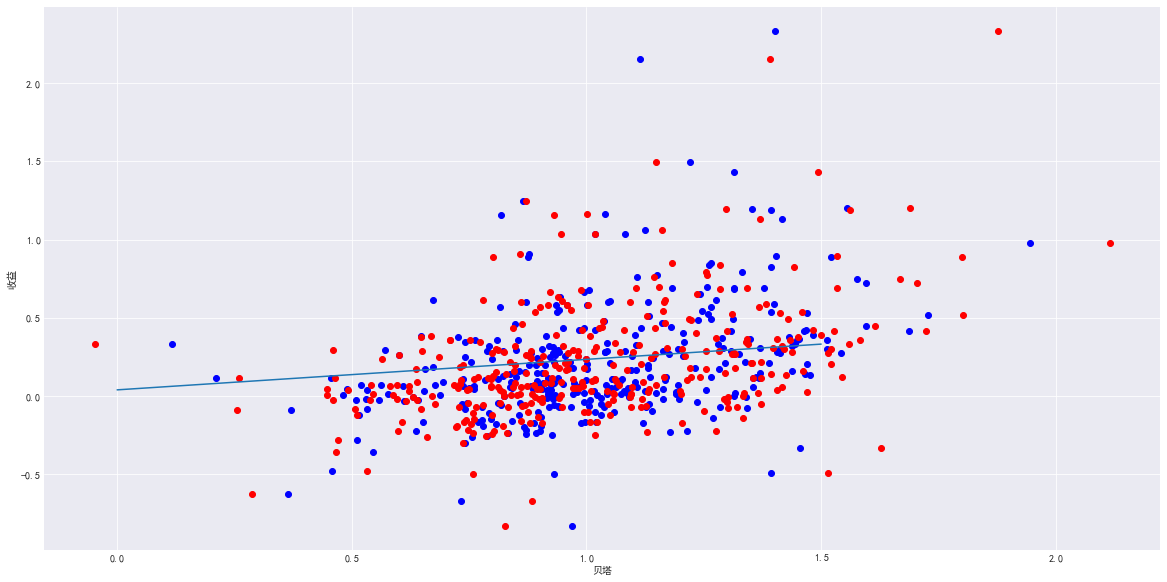

In [46]:
plt.grid(True)
plt.xlabel('贝塔')
plt.ylabel('收益')
plt.plot(b,m,'bo')
plt.plot(a.mean(),m,'ro')
plt.plot(*np.array([[i,i*(x.iloc[:,-1].mean()*YTD-RFR)+RFR] for i in np.linspace(0,1.5,3)]).T)

In [47]:
# 总体均值的界面回归检验
stm.OLS(endog=x.iloc[:,:-1].mean(),exog=stm.add_constant(a.mean().iloc[:-1])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     73.82
Date:                Tue, 05 May 2020   Prob (F-statistic):           3.36e-16
Time:                        16:02:22   Log-Likelihood:                 1738.9
No. Observations:                 335   AIC:                            -3474.
Df Residuals:                     333   BIC:                            -3466.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.000     -4.834      0.000      -0.002      -0.001
0              0.0021      0.000      8.592      0.000       0.002       0.003
==============================================================================
Omnibus:                      100.667   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              360.263
Skew:                           1.286   Prob(JB):                     5.89e-79
Kurtosis:                       7.381   Cond. No.                         6.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 小结
1. beta系数能解释部分资产价格，但是还有明显的不能解释部分；

# 套利定价理论
1. 因素模型（factor models）
2. 无套利均衡（no arbitrage equilibrium）
3. 套利定价理论与资本资产定价模型

$r=XB+\mu$
1. X：因子头寸（因子载荷、因子暴漏）n（资产）乘以k（因子）矩阵；
2. B：因子收益（因子溢价），通过因子模型历史归因得到；
3. $\mu$：特别收益向量，资产收益不能被因子解释的部分；
4. r：资产收益率；

1. [套利定价理论(Arbitrage Pricing Theory，简称APT)](https://wiki.mbalib.com/wiki/%E5%A5%97%E5%88%A9%E5%AE%9A%E4%BB%B7%E7%90%86%E8%AE%BA)
2. [什么是多因子定价模型？APT（套利定价理论）、Fama-French三因子模型之间的关系是怎样的？](https://www.zhihu.com/question/51147196/answer/126812444)

# Fama-French 三因子模型
1. 市场超额收益
2. 规模
3. 账面市值比

## 方法

In [48]:
def f_qcut(h5,fs:list,num:int):
    def _f(x:pd.DataFrame):
        for i in x.columns[1:]:
            x[i]=pd.qcut(x[i],num,labels=False)
        return x
    x=(
        h5['obj_close']
        .set_index(['date','instrument',]).groupby('instrument',sort=False)
        .apply(lambda i:np.log(i).diff())
        .merge(right=h5['obj_weight'].set_index(['date','instrument',]),
               left_index=True,right_index=True,how='inner',sort=False)
        .iloc[:,:-1]
        .merge(right=fac.loc[:,fs].shift(1),#T0期因子影响T1期收益
               left_index=True,right_index=True,how='inner',sort=False)
        .dropna(axis=0,how='any')
        .groupby('date',sort=False).apply(_f)
    )
    x['style']=x[x.columns.to_list()[1:]].apply(lambda x:'-'.join([str(i) for i in x]),axis=1)
    return x
def f_f_ret(x,fac):
    return (
        x.iloc[:,[0,-1]]
        .merge(right=fac.loc[:,['market_cap_float_0']],
               left_index=True,right_index=True,how='inner',sort=False)
        .groupby(['date','style'],sort=True)
        .apply(lambda i:(i.iloc[:,0]*i.iloc[:,-1]).sum()/(i.iloc[:,-1].sum()))
        .unstack(1)
    )

## 因子和衍生因子

In [49]:
h5['fac'].columns

Index(['avg_turn_20', 'avg_turn_240', 'avg_turn_60', 'beta_csi300_60_0',
       'close_0', 'date', 'fs_common_equity_0', 'fs_net_cash_flow_ttm_0',
       'fs_net_profit_yoy_0', 'fs_non_current_liabilities_0',
       'fs_operating_revenue_yoy_0', 'fs_total_equity_0',
       'fs_total_liability_0', 'instrument', 'market_cap_0',
       'market_cap_float_0', 'pb_lf_0', 'pe_ttm_0', 'return_60',
       'swing_volatility_60_0', 'volatility_60_0', 'west_eps_ftm_0'],
      dtype='object')

In [50]:
fac_f={
'market_cap_0':'总市值',
'market_cap_float_0':'流通市值',
'close_0':'收盘价',
'pb_lf_0':'市净率(LF)',
'pe_ttm_0':'市盈率(TTM)',
'fs_net_cash_flow_ttm_0':'经营活动现金净流量(TTM)',
'fs_net_profit_yoy_0':'归属母公司股东的净利润同比增长率',
'fs_operating_revenue_yoy_0':'营业收入同比增长率',
'fs_non_current_liabilities_0':'非流动负债',
'fs_common_equity_0':'普通股权益总额',
'fs_total_liability_0':'负债合计',
'fs_total_equity_0':'所有者权益合计',
'avg_turn_20':'过去i个交易日的平均换手率',
'avg_turn_60':'过去i个交易日的平均换手率',
'avg_turn_240':'过去i个交易日的平均换手率',
'beta_csi300_60_0':'BETA值(沪深300)',
'return_60':'过去i个交易日的收益',
'volatility_60_0':'波动率',
'swing_volatility_60_0':'振幅波动率',
'west_eps_ftm_0':'一致预测每股收益（未来12个月）',
}

In [51]:
# 因子数据整理
fac=(
    h5['fac'].set_index(['date','instrument',])
    .groupby('instrument')
    .apply(lambda i:i.fillna(method='ffill'))
#     .groupby('date')#对应存在无效值，在构建组合的时候不考虑分组
#     .apply(lambda i:i.fillna(i.mean(axis=0),axis=0))
)

In [52]:
fac['x_total_asset']=fac['fs_total_liability_0']+fac['fs_total_equity_0']

In [53]:
def _f(x:pd.DataFrame):
    x['x_total_asset_yoy']=x['x_total_asset'].pct_change().replace(0,None).fillna(method='ffill')
    return x
fac=fac.groupby('instrument',sort=False).apply(_f)

In [54]:
# 检验是否存在无效值
fac.isna().sum().sum(),fac.shape

(63599, (83761, 22))

## 构建分组组合

具体的，将成分股按照账面市值比和流通市值的大小各分成五档，并按照个股在两个指标上的档位取值将它们归类于 5 × 5 = 25 个投资组合中的某一个，由此构建 25 个纯多头投资组合。

In [55]:
x=f_qcut(h5=h5,fs=['market_cap_float_0','pb_lf_0'],num=5)
x=x.groupby(['date','style'],sort=True)['s_dq_adjclose'].mean().unstack(1)
grp_ret=x

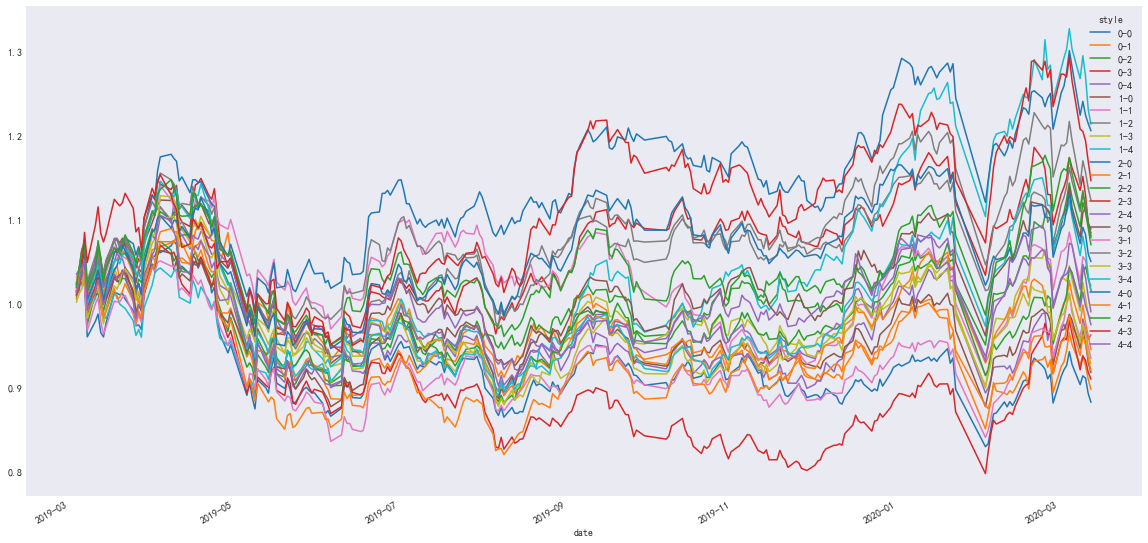

In [56]:
np.exp(x.cumsum()).plot()

## 构建因子组合

### MKT
市场因子：market factor

In [57]:
fac_mkt=np.log(h5['inx_close'].iloc[:,1:].set_index(['date',])).diff().iloc[:,0]-RFR/YTD
fac_mkt.name='mkt'

### SMB
市值因子：Small Minus Big（做多流通市值小的一半、做空流通市值大的一半；）

In [58]:
x=f_qcut(h5=h5,fs=['market_cap_float_0',],num=2)
x=f_f_ret(x,fac)
fac_smb=x.iloc[:,0]-x.iloc[:,1]
fac_smb.name='smb'

### HML
价值因子：High Minus Low（账面市值比升序：做多top30%、做空bottom30%）

In [59]:
x=f_qcut(h5=h5,fs=['pb_lf_0',],num=10)
x=f_f_ret(x,fac)
fac_hml=x.iloc[:,:3].mean(axis=1)-x.iloc[:,-3:].mean(axis=1)
fac_hml.name='hml'

### RMW
盈利因子：Robust Minus Weak（使用营业利润TTM与总市值之比降序，做多top30%、做空bottom30%）

In [60]:
x=f_qcut(h5=h5,fs=['pe_ttm_0',],num=10)
x=f_f_ret(x,fac)
fac_rmw=x.iloc[:,:3].mean(axis=1)-x.iloc[:,-3:].mean(axis=1)
fac_rmw.name='rmw'

### CMA
投资因子：Conservative Minus Aggressive（总资产增长率升序，做多top30%、做空bottom30%）

In [61]:
x=f_qcut(h5=h5,fs=['x_total_asset_yoy',],num=10)
x=f_f_ret(x,fac)
fac_cma=x.iloc[:,:3].mean(axis=1)-x.iloc[:,-3:].mean(axis=1)
fac_cma.name='cma'

### UMD
动量因子：Up Minus Down（N期累积收益率降序，做多top30%、做空bottom30%）

In [62]:
x=f_qcut(h5=h5,fs=['return_60',],num=10)
x=f_f_ret(x,fac)
fac_umd=x.iloc[:,-3:].mean(axis=1)-x.iloc[:,:3].mean(axis=1)
fac_umd.name='umd'

### concat

In [63]:
fac_ret=pd.concat(
    objs=(pd.concat(objs=(fac_smb,fac_hml,fac_rmw,fac_cma,fac_umd),axis=1,join='outer'),
         fac_mkt),
    axis=1,join='inner'
)

In [64]:
fac_ret.shape,fac.shape

((252, 6), (83761, 22))

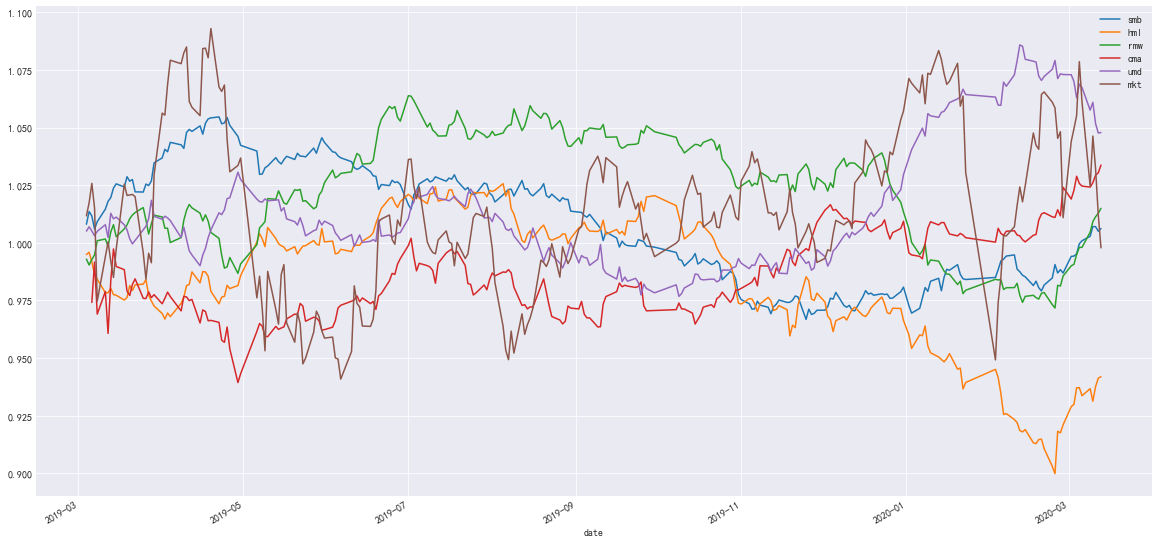

In [65]:
np.exp(fac_ret.cumsum()).plot(grid=True,legend=True)

## 三因子定价-回归分析

### 组合

#### 总体法

In [66]:
x=grp_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_tot_r2))
f_c_rg(*x,ols=ols_tot_p).summary()

0.8227851112016225


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.189
Model:                            OLS   Adj. R-squared (uncentered):              0.078
Method:                 Least Squares   F-statistic:                              1.709
Date:                Tue, 05 May 2020   Prob (F-statistic):                       0.194
Time:                        16:03:50   Log-Likelihood:                          165.44
No. Observations:                  25   AIC:                                     -324.9
Df Residuals:                      22   BIC:                                     -321.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt          6.06e-05   6.95e-05      0.872      0.392   -8.35e-05       0.000
smb           -0.0005      0.000     -1.888      0.072      -0.001    4.67e-05
hml           -0.0003      0.000     -1.206      0.240      -0.001       0.000
==============================================================================
Omnibus:                        0.986   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.611   Jarque-Bera (JB):                0.940
Skew:                           0.407   Prob(JB):                        0.625
Kurtosis:                       2.511   Cond. No.                         4.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 样本法

In [67]:
# 时序回归：R2分析
x=pd.concat(objs=(grp_ret,fac_mkt,fac_smb,fac_hml),axis=1,join='inner')
def _f(y,x):
    a=stm.regression.rolling.RollingOLS(endog=y,exog=x,missing='drop',window=WINDOW).fit()
    return a.rsquared.mean()
x.iloc[:,:-3].apply(func=_f,args=(x.iloc[:,-3:],),axis=0).mean()

0.7949706032882173

In [68]:
f_t_r2(grp_ret,fac_mkt,fac_smb,fac_hml,ols=ols_sam_r2)

0.7949706032882173

In [69]:
# 回归系数（因子）分析
# 时序回归求因子暴漏
x=pd.concat(objs=(grp_ret,fac_mkt,fac_smb,fac_hml),axis=1,join='inner')
def _f(y,x):
    a=stm.regression.rolling.RollingOLS(endog=y,exog=x,missing='drop',window=WINDOW).fit()
    return a.params.mean()
_=x.iloc[:,:-3].apply(func=_f,args=(x.iloc[:,-3:],),axis=0).T
# 截面回归求因子溢价
x=pd.concat(objs=(x.iloc[:,:-3].mean(axis=0),_),axis=1,join='inner')
x=stm.OLS(endog=x.iloc[:,0],exog=x.iloc[:,1:],missing='drop').fit()

In [70]:
f_c_rg(grp_ret,fac_mkt,fac_smb,fac_hml,ols=ols_sam_p).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.257
Model:                            OLS   Adj. R-squared (uncentered):              0.156
Method:                 Least Squares   F-statistic:                              2.539
Date:                Tue, 05 May 2020   Prob (F-statistic):                      0.0827
Time:                        16:03:56   Log-Likelihood:                          166.54
No. Observations:                  25   AIC:                                     -327.1
Df Residuals:                      22   BIC:                                     -323.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt            0.0001   6.78e-05      1.592      0.126   -3.27e-05       0.000
smb           -0.0006      0.000     -2.422      0.024      -0.001   -8.59e-05
hml           -0.0004      0.000     -1.167      0.256      -0.001       0.000
==============================================================================
Omnibus:                        0.964   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.618   Jarque-Bera (JB):                0.939
Skew:                           0.395   Prob(JB):                        0.625
Kurtosis:                       2.474   Cond. No.                         4.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.257
Model:                            OLS   Adj. R-squared (uncentered):              0.156
Method:                 Least Squares   F-statistic:                              2.539
Date:                Tue, 05 May 2020   Prob (F-statistic):                      0.0827
Time:                        16:03:56   Log-Likelihood:                          166.54
No. Observations:                  25   AIC:                                     -327.1
Df Residuals:                      22   BIC:                                     -323.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt            0.0001   6.78e-05      1.592      0.126   -3.27e-05       0.000
smb           -0.0006      0.000     -2.422      0.024      -0.001   -8.59e-05
hml           -0.0004      0.000     -1.167      0.256      -0.001       0.000
==============================================================================
Omnibus:                        0.964   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.618   Jarque-Bera (JB):                0.939
Skew:                           0.395   Prob(JB):                        0.625
Kurtosis:                       2.474   Cond. No.                         4.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 行业

#### 总体法

In [72]:
x=ind_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_tot_r2))
f_c_rg(*x,ols=ols_tot_p).summary()

0.6829341869603335


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.577
Model:                            OLS   Adj. R-squared (uncentered):              0.526
Method:                 Least Squares   F-statistic:                              11.37
Date:                Tue, 05 May 2020   Prob (F-statistic):                    6.83e-05
Time:                        16:03:56   Log-Likelihood:                          178.22
No. Observations:                  28   AIC:                                     -350.4
Df Residuals:                      25   BIC:                                     -346.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt         1.058e-05      0.000      0.105      0.917      -0.000       0.000
smb            0.0004      0.000      1.218      0.235      -0.000       0.001
hml           -0.0010      0.000     -3.412      0.002      -0.002      -0.000
==============================================================================
Omnibus:                        8.995   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.223
Skew:                           1.116   Prob(JB):                       0.0270
Kurtosis:                       4.100   Cond. No.                         4.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 样本法

In [73]:
# 时序回归：R2分析
x=pd.concat(objs=(ind_ret,fac_mkt,fac_smb,fac_hml),axis=1,join='inner')
def _f(y,x):
    a=stm.regression.rolling.RollingOLS(endog=y,exog=x,missing='drop',window=WINDOW).fit()
    return a.rsquared.mean()
x.iloc[:,:-3].apply(func=_f,args=(stm.add_constant(x.iloc[:,-3:]),),axis=0).mean()

0.6837488922351584

In [74]:
# 回归系数（因子）分析
# 时序回归求因子暴漏
x=pd.concat(objs=(ind_ret,fac_mkt,fac_smb,fac_hml),axis=1,join='inner')
def _f(y,x):
    a=stm.regression.rolling.RollingOLS(endog=y,exog=x,missing='drop',window=WINDOW).fit()
    return a.params.mean()
_=x.iloc[:,:-3].apply(func=_f,args=(stm.add_constant(x.iloc[:,-3:]),),axis=0).T
# 截面回归求因子溢价
x=pd.concat(objs=(x.iloc[:,:-3].mean(axis=0),_),axis=1,join='inner')
x=stm.OLS(endog=x.iloc[:,0],exog=stm.add_constant(x.iloc[:,2:]),missing='drop').fit()

In [75]:
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     13.75
Date:                Tue, 05 May 2020   Prob (F-statistic):           2.00e-05
Time:                        16:03:58   Log-Likelihood:                 180.94
No. Observations:                  28   AIC:                            -353.9
Df Residuals:                      24   BIC:                            -348.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -1.248      0.224      -0.002       0.000
mkt            0.0008      0.001      1.403      0.173      -0.000       0.002
smb            0.0005      0.000      1.914      0.068   -3.82e-05       0.001
hml           -0.0014      0.000     -3.727      0.001      -0.002      -0.001
==============================================================================
Omnibus:                        3.305   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                1.979
Skew:                           0.617   Prob(JB):                        0.372
Kurtosis:                       3.417   Cond. No.                         16.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 个股

#### 总体法

In [76]:
x=obj_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_tot_r2))
f_c_rg(*x,ols=ols_tot_p).summary()

0.4043294068986359


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.317
Model:                            OLS   Adj. R-squared (uncentered):              0.311
Method:                 Least Squares   F-statistic:                              51.48
Date:                Tue, 05 May 2020   Prob (F-statistic):                    2.40e-27
Time:                        16:03:59   Log-Likelihood:                          1771.0
No. Observations:                 335   AIC:                                     -3536.
Df Residuals:                     332   BIC:                                     -3525.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt         4.133e-05   6.44e-05      0.641      0.522   -8.54e-05       0.000
smb            0.0005      0.000      3.364      0.001       0.000       0.001
hml           -0.0013      0.000     -9.731      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      114.293   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              960.130
Skew:                           1.163   Prob(JB):                    3.24e-209
Kurtosis:                      10.961   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 样本法

In [77]:
x=obj_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_sam_r2))
f_c_rg(*x,ols=ols_sam_p).summary()

d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\regression\rolling.py:216: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\regression\rolling.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)


0.4395725849152366


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.201
Model:                            OLS   Adj. R-squared (uncentered):              0.193
Method:                 Least Squares   F-statistic:                              27.78
Date:                Tue, 05 May 2020   Prob (F-statistic):                    4.73e-16
Time:                        16:04:35   Log-Likelihood:                          1744.5
No. Observations:                 335   AIC:                                     -3483.
Df Residuals:                     332   BIC:                                     -3472.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt         9.548e-05   6.95e-05      1.373      0.171   -4.13e-05       0.000
smb            0.0007      0.000      5.200      0.000       0.000       0.001
hml           -0.0011      0.000     -7.678      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      132.260   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1582.906
Skew:                           1.279   Prob(JB):                         0.00
Kurtosis:                      13.337   Cond. No.                         2.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# alphalens
见《alphalens.ipynb》

# Fama-MacBeth(FM)回归
步骤：
1. 时序回归>因子暴漏：全T期
2. 截面回归>因子溢价：t期回归，然后均值

In [78]:
# 时序回归求因子暴漏
x=pd.concat(objs=(grp_ret,fac_mkt,fac_smb,fac_hml),axis=1,join='inner')
def _f(y,x):
    a=stm.OLS(endog=y,exog=x,missing='drop').fit()
    return a.params
_=x.iloc[:,:-3].apply(func=_f,args=(x.iloc[:,-3:],),axis=0).T
# 单期截面回归求因子溢价
def _f(y,x):
    a=ols_tot_p(y,x)
    b=y-(x*a).sum(axis=1)
    return pd.concat(objs=(a,b),axis=0)
y=x.iloc[:,:-3].apply(func=_f,args=(_.iloc[:,:],),axis=1,raw=False)
# x=pd.concat(objs=(x.iloc[:,:-3].mean(axis=0),_),axis=1,join='inner')
# x=stm.OLS(endog=x.iloc[:,0],exog=stm.add_constant(x.iloc[:,2:]),missing='drop').fit()

## 分组组合

### 总体法

In [79]:
x=grp_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_tot_r2))
f_c_fm(*x,ols=ols_tot_p)[1]

0.8227851112016225


0.172599811677981

### 样本法

In [80]:
x=grp_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_sam_r2))
f_c_fm(*x,ols=ols_sam_p)[1]

0.7949706032882173


0.24219769456051077

## 行业

### 总体法

In [81]:
x=ind_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_tot_r2))
f_c_fm(*x,ols=ols_tot_p)[1]

0.6829341869603335


0.5534048415371433

### 样本法

In [82]:
x=ind_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_sam_r2))
f_c_fm(*x,ols=ols_sam_p)[1]

0.6817284119490402


0.6291830310438629

## 个股

### 总体法

In [83]:
x=obj_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_tot_r2))
f_c_fm(*x,ols=ols_tot_p)[1]

0.4043294068986359


0.3139733239989563

### 样本法

In [84]:
x=obj_ret,fac_mkt,fac_smb,fac_hml
print(f_t_r2(*x,ols=ols_sam_r2))
f_c_fm(*x,ols=ols_sam_p)[1]

0.4395725849152366


0.19674033412578618

In [85]:
# 资产定价：对风险资产未来收益的预期
(_*y.iloc[:,:3].mean(axis=0)).sum(axis=1)

0-0   -0.000226
0-1   -0.000118
0-2   -0.000001
0-3   -0.000123
0-4    0.000060
1-0   -0.000082
1-1   -0.000124
1-2   -0.000014
1-3   -0.000056
1-4    0.000164
2-0   -0.000004
2-1   -0.000093
2-2    0.000027
2-3   -0.000050
2-4    0.000052
3-0    0.000214
3-1    0.000019
3-2    0.000190
3-3    0.000242
3-4    0.000086
4-0    0.000076
4-1    0.000075
4-2    0.000164
4-3    0.000410
4-4    0.000322
dtype: float64

# 对比
1. 经典回归、FM
2. 总体法、样本法
3. 分组组合、行业、个股
4. 单因子、三因子

In [86]:
%%time
print(datetime.now())
r=[]
def _f(x):
    y=eval(x)
    y.name=x
    return y
y=[_f(i) for i in ('grp_ret','ind_ret','obj_ret')]
f=[(lambda x:[_f(i) for i in x])(i) for i in (('ols_tot_r2','ols_tot_p'),('ols_sam_r2','ols_sam_p'))]
# 单因子、经典回归
x=(fac_mkt,)#单因子
r.extend([
    ('1f:rg:{}:{}'.format(yi.name,fi[1].name),f_t_r2(yi,*x,ols=fi[0]),f_c_rg(yi,*x,ols=fi[1]).rsquared)
    for yi in y for fi in f
])
# 单因子、FM回归
x=(fac_mkt,)#单因子
r.extend([
    ('1f:fm:{}:{}'.format(yi.name,fi[1].name),f_t_r2(yi,*x,ols=fi[0]),f_c_fm(yi,*x,ols=fi[1])[1])
    for yi in y for fi in f
])
# 三因子、经典回归
x=(fac_mkt,fac_smb,fac_hml,)#单因子
r.extend([
    ('3f:rg:{}:{}'.format(yi.name,fi[1].name),f_t_r2(yi,*x,ols=fi[0]),f_c_rg(yi,*x,ols=fi[1]).rsquared)
    for yi in y for fi in f
])
# 三因子、FM回归
x=(fac_mkt,fac_smb,fac_hml,)#单因子
r.extend([
    ('3f:fm:{}:{}'.format(yi.name,fi[1].name),f_t_r2(yi,*x,ols=fi[0]),f_c_fm(yi,*x,ols=fi[1])[1])
    for yi in y for fi in f
])
x=pd.DataFrame(r)

2020-05-05 16:05:23.444740


d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\regression\rolling.py:199: RuntimeWarning: invalid value encountered in double_scalars
  s2 = ssr / (nobs - tot_params)


Wall time: 2min 48s


In [87]:
y=x.iloc[:,0].str.split(':',expand=True).merge(right=x.iloc[:,1:],left_index=True,right_index=True)

## 时序回归R2

In [88]:
y.set_index(y.columns.tolist()[:4]).iloc[:,0].unstack([0,1])

0                        1f                  3f          
1_x                      rg        fm        rg        fm
2_x     3                                                
grp_ret ols_sam_p  0.766461  0.766461  0.794971  0.794971
        ols_tot_p  0.815678  0.815678  0.822785  0.822785
ind_ret ols_sam_p  0.635812  0.635812  0.681728  0.681728
        ols_tot_p  0.666441  0.666441  0.682934  0.682934
obj_ret ols_sam_p  0.390632  0.390632  0.439573  0.439573
        ols_tot_p  0.391187  0.391187  0.404329  0.404329

观察：
1. 三因子>单因子
2. 总体>样本
3. 组合>行业>个股

## 截面回归R2

In [89]:
y.set_index(y.columns.tolist()[:4]).iloc[:,1].unstack([0,1])

0                        1f                  3f          
1_x                      rg        fm        rg        fm
2_x     3                                                
grp_ret ols_sam_p  0.019741 -0.000060  0.257202  0.242198
        ols_tot_p  0.018735 -0.001087  0.188982  0.172600
ind_ret ols_sam_p  0.702494  0.212946  0.648814  0.629183
        ols_tot_p  0.688709  0.176477  0.577047  0.553405
obj_ret ols_sam_p  0.331725  0.106683  0.200638  0.196740
        ols_tot_p  0.334447  0.110306  0.317485  0.313973

观察：
1. fm:三因子>单因子
2. 样本法>总体法（行业和分组，个股相反）
3. 行业>个股>分组组合

## 定价

In [90]:
def _f(y):
    print(datetime.now())
    def _f(x):
        y=eval(x)
        y.name=x
        return y
    r=[]
#     y=grp_ret
    f=[(lambda x:[_f(i) for i in x])(i) for i in (('ols_tot_r2','ols_tot_p'),('ols_sam_r2','ols_sam_p'))]
    g=[_f(i) for i in ('f_c_rg','f_c_fm')]
    def _f(y,*x,rg,ols):
        f=f_t_f(y,*x,ols=ols)
        if rg==f_c_rg:
            a=rg(y,*x,ols=ols).params
        elif rg==f_c_fm:
            a=rg(y,*x,ols=ols)[0]
        else:
            raise 'error!'
        return (a*f).sum(axis=1)
    # 单因子
    x=(fac_mkt,)#单因子
    r.extend([
        list(['1f:{}:{}'.format(gi.name,fi[1].name)])+list(_f(y,*x,rg=gi,ols=fi[1]))
        for gi in g for fi in f
    ])

    # 三因子
    x=(fac_mkt,fac_smb,fac_hml,)#单因子
    r.extend([
        list(['3f:{}:{}'.format(gi.name,fi[1].name)])+list(_f(y,*x,rg=gi,ols=fi[1]))
        for gi in g for fi in f
    ])
    return pd.DataFrame(r)

### 分组组合

In [91]:
%%time
x=_f(grp_ret)

2020-05-05 16:08:12.515114
Wall time: 9.96 s


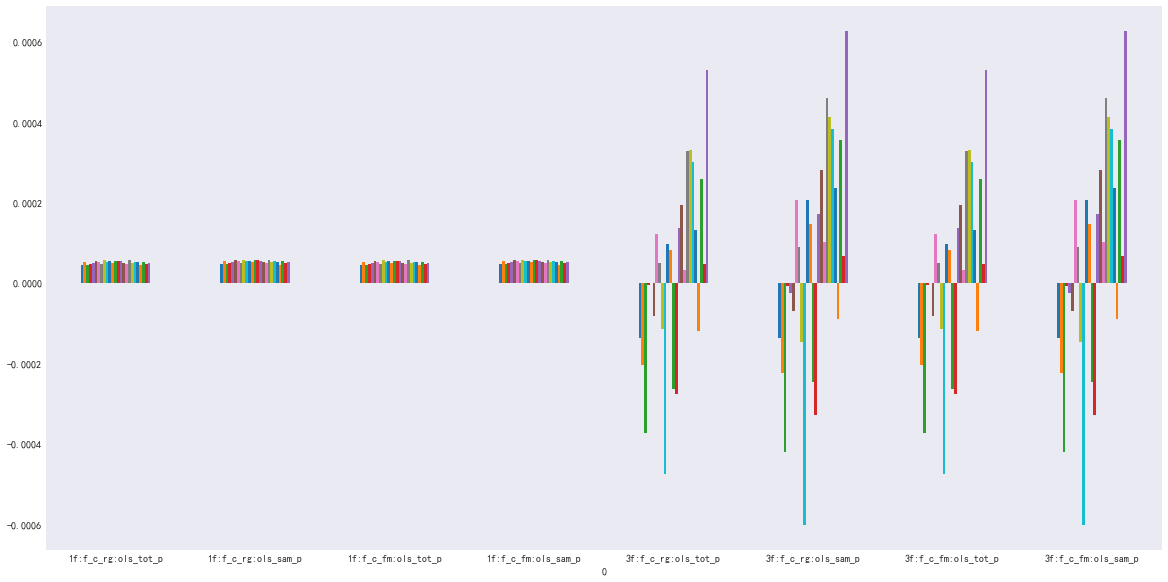

In [92]:
x.set_index(x.columns.tolist()[0]).plot.bar(rot=0,legend=False)

### 行业

In [93]:
%%time
x=_f(ind_ret)

2020-05-05 16:08:23.328290
Wall time: 11.1 s


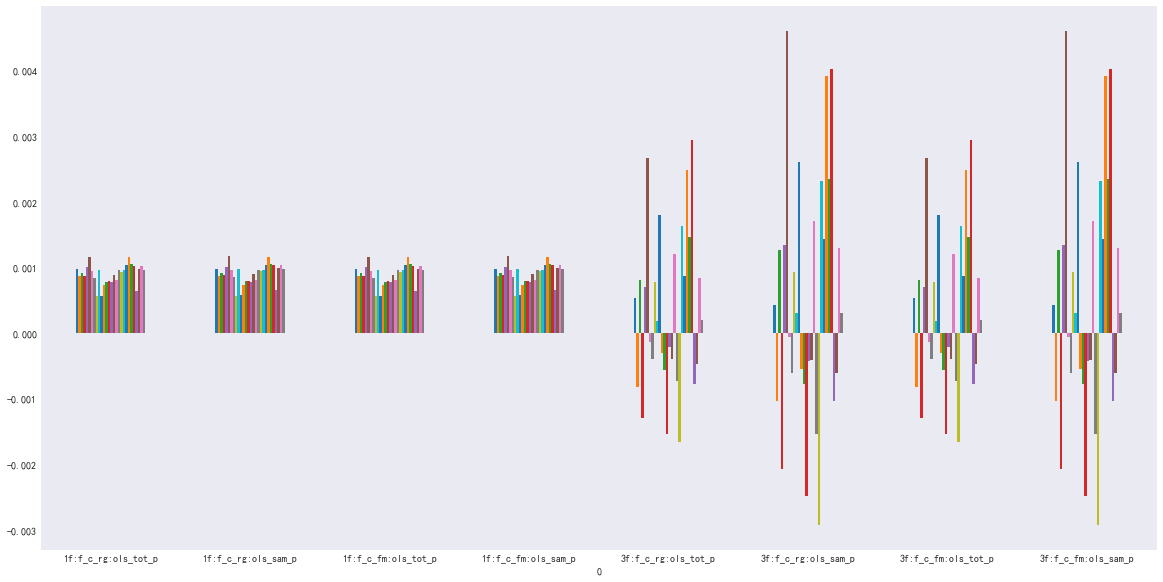

In [94]:
x.set_index(x.columns.tolist()[0]).plot.bar(rot=0,legend=False)

### 个股

In [95]:
%%time
x=_f(obj_ret)

2020-05-05 16:08:35.189510


d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\regression\rolling.py:216: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\regression\rolling.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
d:\pp\miniconda3\envs\pyqi\lib\site-packages\statsmodels\regression\rolling.py:199: RuntimeWarning: invalid value encountered in double_scalars
  s2 = ssr / (nobs - tot_params)


Wall time: 1min 26s


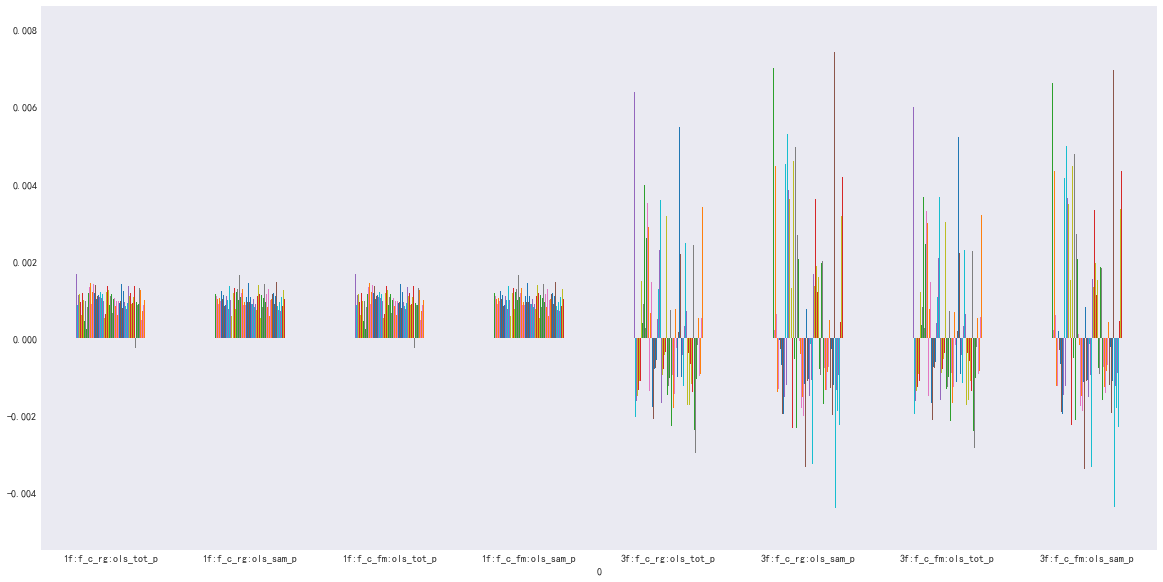

In [96]:
x.set_index(x.columns.tolist()[0]).plot.bar(rot=0,legend=False)

观察：
1. 因子数量的影响较大
2. 总体和样本的影响微小
3. 除此之外，差距不大

# 因子显著性
目的：
1. 判定因子有效性
2. 挖掘因子

步骤:

0. 计算真实数据中原始因子X的解释程度（即，回归截距项）
1. 对候选因子X做正交化（demean）处理得到OX，以此构建零假设：OX无法解释资产（个股、行业或者分组组合）预期收益的截面差异；
2. 使用每个正交化后的因子OX和系列资产一一回归分析，找出OX中最能解释资产预期收益率截面差异的因子；
3. 通过自助法（Bootstrap）采样进行大量上述实验，获得仅凭运气造成的显著性经验分布，这就是零假设（仅靠运气）下显著性的分布；
4. 如果来自真实数据中某原始因子X的解释程度在这个分布的5%分位阈值之下，则该因子真正有效；
5. 重复上述步骤，知道找到全部显著有效因子；

## 因子的定价错误
分别使用因子和资产收益率做时序回归。对于每个因子，得到N个（资产个数）回归截距，它们是这些投资组合在使用该因子时的定价错误。使用这些截距绝对值的中位数作为该因子解释这些投资组合的能力。定价错误低意味着解释力度高，因此该中位数越小说明因子越有效。

## 定价错误分布
从自助采样样本中得到仅靠运气的定价错误分布。使用该分布分位数作为阈值，如果原始因子获得的定价错误小于该阈值，我们就说该因子在$X\%$的显著性水平下有效。

## 自主采样法
1. Moving Block Bootstrap（Kunsch 1989, Liu and Singh 1992）；
2. Circular Block Bootstrap（Politis and Romano 1992）;
3. Stationary Bootstrap（Politis and Romano 1994）。

## code

In [98]:
fac_ret.columns

Index(['smb', 'hml', 'rmw', 'cma', 'umd', 'mkt'], dtype='object')

In [115]:
fac_ret['zeo']=0#建立零列

In [126]:
%%time
# 资产
y=ind_ret
# 求解真实数据中原始因子X的解释程度（即定价错误，越小越显著）
def _f1(y,x):# 计算定价错误
    return stm.OLS(endog=y,exog=stm.add_constant(x),missing='drop').fit().params.values[0]
def _f2(x,y,z):# 求定价错误的绝对值的中位数
    return y.apply(_f1,axis=0,args=(pd.concat(objs=(x,z),join='inner',axis=1),)).abs().median()
a=y.merge(# data
    right=fac_ret,
    left_index=True,right_index=True,how='inner',sort=False,
)
x=a.loc[:,[ 'umd','cma', 'mkt',]]# 因子组合收益
y=a.loc[:,y.columns.to_list()]# 资产收益
z=a.loc[:,['zeo', 'hml','rmw','smb',]]# 验证通过的有效因子
print(x.apply(_f2,axis=0,args=(y,z,)))
# 计算正交化因子得到OX
x=x-x.apply(_f1,axis=0,args=(z,))# 第一次的话是因子组合的收益率减去各自的收益率均值,后面的循环，使用因子收益率减去回归截距项
a=pd.concat(objs=(x,y,z),axis=1,join='inner')
# 自助采样，并计算每次采样的最小定价错误
def _f3(x,g:float=.1):
    pos=np.random.randint(x.shape[0])
    num=0
    res=[]
    while num<x.shape[0]:
        res.append(x.iloc[pos,:])
        if np.random.uniform()<g:
            pos=np.random.randint(x.shape[0])
        else:
            pos+=1
            pos=0 if pos>=x.shape[0] else pos
        num+=1
    return pd.DataFrame(data=res,columns=x.columns)
r=[]
np.random.seed(0)
for i in range(5):#自助采样的次数
    b=_f3(x=a,g=.2)
    r.append(
        b.loc[:,x.columns.to_list()]
        .apply(_f2,axis=0,args=(
            b.loc[:,y.columns.to_list()],
            b.loc[:,z.columns.to_list()]
        )).min()
    )
print(np.percentile(r,5))# 分位阈值

umd    0.000340
cma    0.000449
mkt    0.000361
dtype: float64
0.00039767923836812706
Wall time: 4.26 s


**小结：**
1. 按照自助采样+正交化的方法分别对资产（个股、行业、因子分组组合）做因子显著性检验；
2. 如果没有因子小于阈值，但是把定价错误最小的因子列为有效因子，剩下的因子检验中发现有效因子存在，那么这些因子组合可能是一个有效因子